# COMPRESSOR MASS MODEL

*Authors: N. Luglio, F. Pollet, E. Valette, M. Rebière - 2019* <br>
*Updated: F. Pollet - 2020*
***

This notebook provides a mass model for a turbo-compressor driven by an electric motor. The compressor provides compressed air to the cathode inlet of the fuel cell. <br>

The table below summarizes the status of compressors used in fuel cell systems according to several sources. These values can be used as references in the sizing process, although decisive factors for exact compressor sizing will be stack operating pressure, stack power and stoichiometric conditions.

|Source | Stack power [kW] | Input compressor power at 100% flow [kW] | Weight [kg] | Volume [L]| Remarks |
| --- | --- | --- | ---| ---| --- |
| U.S. Department of Energy | 80 | 14 (8 with expander) | 15 | 15| 2020 targets |
| Inn-Balance Project | 100 | 12 | 10 | 9 | Celeroton compressors |
| EVERYWH2ERE project| 100 | 15 | 8.5 | 7 | Fischer EMTCT-120k |

### References
[1] DOE Technical Targets for Fuel Cell System Humidifiers and Air Compression Systems, https://www.energy.gov/eere/fuelcells/doe-technical-targets-fuel-cell-system-humidifiers-and-air-compression-systems

[2] Inn-Balance FCH project, www.innbalance-fch-project.eu 

[3] Celeroton AG turbo-compressors, https://www.celeroton.com/en/products/compressors.html

[4] Fischer EMTCT-120k Air, https://shop.fischerspindle.com/Fischer/Electric_Micro-Turbo-Compressor/EMTCT-120k-Air

[5] EVERYWH2ERE project, D1.3 – “EVERYWH2ERE Gensets Enabling Technologies (FC and H2 Storage) Assessment Report”, http://www.everywh2ere.eu/

[6] S. H. Teichel, "Design Considerations for the components of electrically powered active high-lift systems in civil aircraft", 2014

***

## Compressor analytical model

The following inputs are considered for the physical modeling of the compressor:
- the pressure of the inlet air, $p_1$ (air entering the compressor)
- the pressure of the outlet air, $p_{2}$ (air entering the cathode of the fuel cell)
- the temperature of the inlet air, $T_1$ (air entering the compressor)
- the pressure coefficient $c_p$ of air
- the isentropic efficiency $\eta$ of the compressor (considered constant here)
- the conversion efficiency $\eta_{mot}$ of the elec. motor driving the compressor
- the sizing power $P_{fc}$ of the fuel cell
- the hydrogen mass flow $m_{h2}$ at the fuel cell anode and the voltage of one cell $V_{cell}$
- the stoichiometry factor ($SF$), which is the ratio of $O_2$ molecules consumed by the fuel cell over the ratio of $H_2$. A typical value for PEMFC is $SF=2$

These input parameters yield the following equations:

- Air flow rate required by the fuel cell:
    $$\dot{m}_{air}=\frac{3.57^* 10^{-7}SF^*P_{fc}}{V_{cell}}$$

- Temperature variation through the compressor:
$$\Delta T = \frac{T_1}{\eta}(\frac{p_2}{p_1}^{\frac{\gamma-1}{\gamma}}-1)$$

- Compressor mechanical power:
$$P_{cmp}=c_p \dot{m}_{air}\Delta T$$

- Electrical power required to drive the compressor:
$$P_{el}=\frac{P_c}{\eta_{mot}}$$

## Compressor mass model

The compressor weight is estimated from a linear interpolation over the results presented in the article "**Design Considerations for the components of electrically powered active high-lift systems in civil aircraft, S. H. Teichel 2014"**.

| Compressor input power (kW) | Compressor mass (kg) |
| --- | --- | 
| 177 | 12.1 |
| 140 | 10.9 |
| 107 | 9.6 |
| 78 | 8.4 |
| 53 | 7.1|

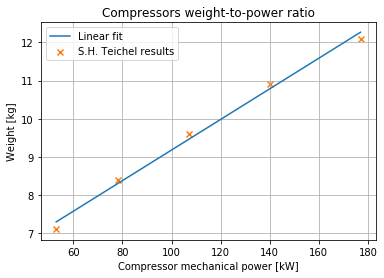

These values yield the following equation:
$$ m_{cmp} [kg] = 5.1724 + 0.0401 P_{cmp} [kW] $$

In addition, the mass of the electrical motor driving the compressor has to be taken into account. S.H. Teichel provides the following equation for an air-cooled e-motor:

$$ m_{mot} [kg] = 6.08 + 0.077 P_{elec} [kW] $$


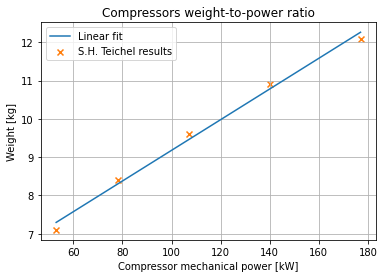

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

power_input = np.array([53,78,107,140,177]).reshape(-1,1)
mass=np.array([7.1,8.4,9.6,10.9,12.1])

weight_model = LinearRegression().fit(power_input, mass)

plt.scatter(power_input,mass,label='S.H. Teichel results',marker='x',color='tab:orange')
plt.plot(power_input,weight_model.predict(power_input),label='Linear fit')
plt.grid()
plt.title('Compressors weight-to-power ratio')
plt.xlabel('Compressor mechanical power [kW]')
plt.ylabel('Weight [kg]')
plt.legend()
plt.show()

***
## Application

In [30]:
# INPUTS
p_1=0.6 #bar #pressure inlet air
p_2=2 #bar #pressure air at fuel cell's anode--> outlet pressure for compressor
T_1=250 #328 #K  #input temperature for compressor # normal external conditions are assumed
cp=1004  #W/((kg/s)*k)  #pressure coefficient of air
P_fc=1000000 #W #Power produced by the fuel cell
V_cell=0.65 #V  #Voltage in one cell
eta_mot=0.95 #mechanical efficiency of the motor driving the compressor
eta=0.9 #compressor isentropic efficiency, needs to be modified according to the manufacturer's specifications

# INTERMEDIATE CALCULATIONS
pressure_ratio=p_2/p_1 # pressure ratio
flow_rate=3.57*(10**(-7))*2*P_fc/V_cell #kg/s
DT=T_1*(pressure_ratio**((1.4-1)/1.4)-1)/eta # temperature variation
T_out=T_1+DT # outlet temperature
P_c=cp*DT*flow_rate # compressor mechanical power (W)
P_el=P_c/eta_mot # compressor motor electrical power (W)

In [33]:
# MASS CALCULATION
M_cmp = 5.1724 + 0.0401 *P_c/1000
M_mot = 6.08 + 0.077 * P_el/1000
M = M_cmp + M_mot
print("Mass flow rate: ", flow_rate, "kg/s")
print("Compressor mechanical power: ", P_c/1000, "kW")
print("E-motor power: ", P_el/1000, "kW")
print("Weight of the compressor alone: ",M_cmp,"kg")
print("Weight of the moto-compressor: ",M,"kg")

Mass flow rate:  1.0984615384615384 kg/s
Compressor mechanical power:  125.77688089274028 kW
E-motor power:  132.3967167292003 kW
Weight of the compressor alone:  10.216052923798884 kg
Weight of the moto-compressor:  26.49060011194731 kg


----------------------

# Parametric study

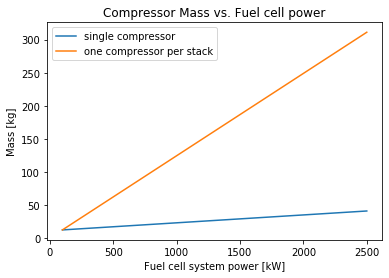

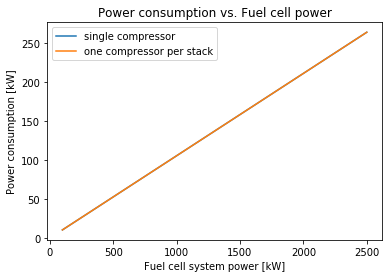

In [4]:
import numpy as np 
from matplotlib import pyplot as plt

def mass_cmp(p_1,p_2,T_1,P_fc):
    # PARAMETERS
    cp=1004  #W/((kg/s)*k)  #pressure coefficient of air
    V_cell=0.65 #V  #Voltage in one cell
    eta_el_mech=0.9 #mechanical efficiency of the motor driving the compressor
    eta=0.7 #compressor isentropic efficiency, needs to be modified according to the manufacturer's specifications

    # INTERMEDIATE CALCULATIONS
    pressure_ratio=p_2/p_1 # pressure ratio
    flow_rate=3.57*(10**(-7))*2*P_fc/V_cell #kg/s
    DT=T_1*(pressure_ratio**((1.4-1)/1.4)-1)/eta # temperature variation
    T_out=T_1+DT # outlet temperature
    P_c=cp*DT*flow_rate/1000 # compressor mechanical power (kW)
    P_el=P_c/eta_el_mech # compressor motor electrical power (kW)

    # MASS CALCULATION
    M_cmp = 5.1724 + 0.0401 *P_c
    M_mot = 6.08 + 0.077 * P_el
    M = M_cmp + M_mot
    return P_el, M, T_out


P_1 = 0.522
P_2 = 1
T_1 = 273.15+21.7
P_fc = [100*(i+1) for i in range(25)]

# One compressor per system
power_array = []
weight_array = []

for i in range(len(P_fc)):
    P_el, M, T_out = mass_cmp(P_1,P_2,T_1,P_fc[i]*1000)
    power_array.append(P_el)
    weight_array.append(M)
    #print("E-motor power: ", P_el/1000, "kW")
    #print("Weight of the moto-compressor: ",M,"kg")
    #print("Outlet temperature: ",T_out-273.15,"°C")
    #print("--------------------------------")

# n compressors per system (n stacks of 100kW)
n_array = [P_fc[i]/100 for i in range(len(P_fc))]
power_array_n = [power_array[0]*n_array[i] for i in range(len(P_fc))]
weight_array_n = [weight_array[0]*n_array[i] for i in range(len(P_fc))]
    
    
plt.plot(P_fc,weight_array, label = 'single compressor')
plt.plot(P_fc,weight_array_n, label='one compressor per stack')
plt.xlabel('Fuel cell system power [kW]')
plt.ylabel('Mass [kg]')
plt.title('Compressor Mass vs. Fuel cell power')
plt.legend()
plt.show()

plt.plot(P_fc,power_array, label = 'single compressor')
plt.plot(P_fc,power_array_n, label = 'one compressor per stack')
plt.xlabel('Fuel cell system power [kW]')
plt.ylabel('Power consumption [kW]')
plt.title('Power consumption vs. Fuel cell power')
plt.legend()
plt.show()
